In [1]:
pkg load statistics
pkg load communications

# HW 3: Neyman Pearson for 2 Signals in Gaussian Noise
## Zachary Neveu


The Neyman-Pearson lemma allows for designing a classifier based on a maximum acceptable bounds on one of the two types of errors (usually $P_{FA}^*$ is specified). Neyman-Pearson sets the decision boundary, $\gamma$ so that this condition is met, rather than attempting to minimize the total error the way MAP or ML detection would.  In the case that the prior probabilities and costs are equal, this trade does not provide benefits, however when the priors and/or costs aren't equal, this tradeoff can have great benefits.  One example of this was the original use case, radar systems.  The probability of a target being present is very low, however if a target is present, it is very important that it be detected.  By allowing for more false alarms, The probability of a missed detection goes down.

## 1)
### i)

$$ H_0: Y = A_0 + z, z\sim \mathcal{N}(0, \sigma_z) $$
$$ H_1: Y = A_1 + z, A1 \gt A0$$

$$Y_0 \sim \mathcal{N}(A_0, \sigma_z)$$ 
$$Y_1 \sim \mathcal{N}(A_1, \sigma_z)$$

Looking at Fig. 1, is the right tail of the left gaussian, shaded in purple.  The area of this is then given by the form of the Q function shown below.  $P_{CD}$ is also the area under the gaussian, and so is also a form of the Q function. $\gamma$ can be found by rearranging $P_{FA}$.

$$P_{FA}^* = Q(\frac{\gamma - A_0}{\sigma_z}) \rightarrow P_{CD} = Q(\frac{\gamma - A_1}{\sigma_z})$$

$$\gamma = \sigma_z * Q^{-1}(P_{FA}^*) + A_0$$

### ii)

$P_{CD}$ can be found by plugging in our expression for $\gamma$ into our function for $P_{CD}$ from part i.  It makes sense that $P_{CD}$ gets better if there is more space between the means, less noise, or a larger allowed probability of false alarm.

$$ P_{CD} = Q(Q^{-1}(P_{FA}^*)+\frac{A_0 - A_1}{\sigma_z})$$

In [2]:
maxpfa = 0.2;
sigmazsq = 1;
A0 = db2mag(10);
A1 = db2mag(15);
gamma = qfuncinv(maxpfa) * sigmazsq + A0;

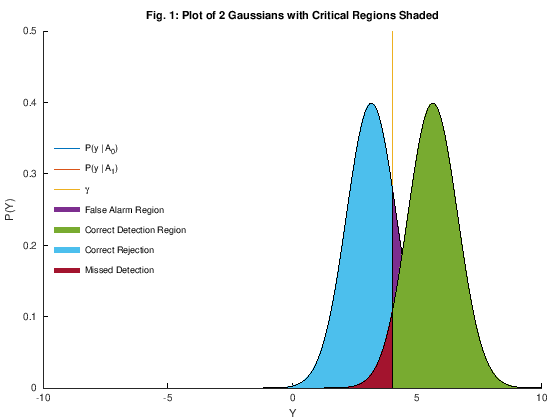

In [5]:
r = linspace(-5, 5);
hold on
plot(r, normpdf(r-A0), 'DisplayName', 'P(y | A_0)')
plot(r, normpdf(r-A1), 'DisplayName', 'P(y | A_1)')
plot([gamma gamma], [0 0.5], 'DisplayName', '\gamma')
detection_reg = linspace(gamma, 10);
no_detect_reg = linspace(-5, gamma);
area(detection_reg, normpdf(detection_reg - A0), 'DisplayName', 'False Alarm Region')
area(detection_reg, normpdf(detection_reg - A1), 'DisplayName', 'Correct Detection Region')
area(no_detect_reg, normpdf(no_detect_reg - A0), 'DisplayName', 'Correct Rejection')
area(no_detect_reg, normpdf(no_detect_reg - A1), 'DisplayName', 'Missed Detection')
title('Fig. 1: Plot of 2 Gaussians with Critical Regions Shaded')
ylabel('P(Y)')
xlabel('Y')
legend('Location', 'west')
legend('boxoff')

## 2)

In [1]:
function [samps, classes] = generate(A0, A1, sigma, PA0, nSamples)
    gen0 = mvnrnd(A0, sigma, nSamples);
    gen1 = mvnrnd(A1, sigma, nSamples);
    classes = rand(nSamples, 1) > PA0;
    samps = gen0 .* !classes + gen1 .* classes;
end

In [2]:
function [PCD, PFA] = detect(A0, sigmasq, maxpfa, samples, classes)
    gamma = sigmasq * qfuncinv(maxpfa) + A0;
    cds = and(samples > gamma, classes);
    fas = and(samples > gamma, !classes);
    PCD = sum(cds) ./ sum(classes);
    PFA = sum(fas) ./ sum(!classes);
end

### i)

In [7]:
sigmaz = 1;
a0 = db2mag(10);
a1 = db2mag(15);
p0 = 0.3;
maxpfa = 0.1;
num_trials = 10000;
[samps, cls] = generate(a0, a1, sigmaz, p0, num_trials);

In [8]:
[pcd, pfa] = detect(a0, sigmaz, maxpfa, samps, cls)

pcd =  0.87622
pfa =  0.099934


### ii)

Fig. 2 shows the theoretical and experimental values of $P_{CD}$ compared across a variety of $P_{FA}^*$.  The values match up, and increase with $P_{FA}^*$ as they should.

In [12]:
det_w_args = @(pfa)(detect(a0, sigmaz, pfa, samps, cls));
pfas = 0:0.01:1;
[pcds_experimental, pfas_experimental] = det_w_args(pfas);

In [13]:
pcd_theory = @(pfa)((qfunc((sigmaz*qfuncinv(pfa) + a0 - a1)/sigmaz)));
pcds_theoretical = pcd_theory(pfas);

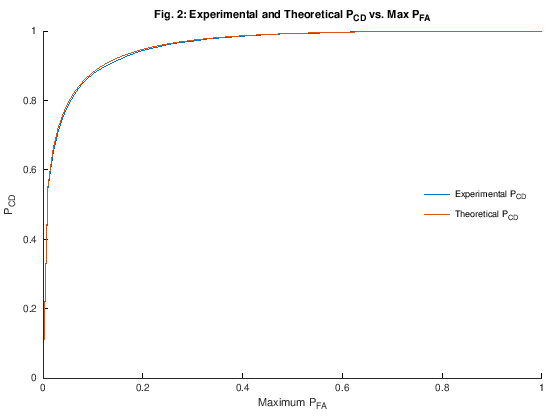

In [14]:
hold on
plot(pfas, pcds_experimental, 'DisplayName', 'Experimental P_{CD}')
plot(pfas, pcds_theoretical, 'DisplayName', 'Theoretical P_{CD}')
title('Fig. 2: Experimental and Theoretical P_{CD} vs. Max P_{FA}')
xlabel('Maximum P_{FA}')
ylabel('P_{CD}')
legend('Location', 'east')
legend('boxoff')

### iii)
Plotting the designed vs. experimental values for $P_{FA}$, shows that the experimental values match up almost exactly with the theoretical values.  One thing to note, however, is that the experimental $P_{FA}$ can exceed the theoretical value, particularly if the number of experiments is low.

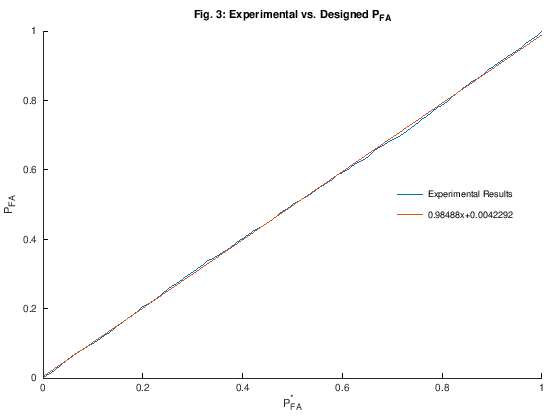

In [15]:
fit = polyfit(pfas, pfas_experimental, 1);
pval = polyval(fit, pfas);
hold on
plot(pfas, pfas_experimental, 'DisplayName', 'Experimental Results')
plot(pfas, pval, 'DisplayName', [num2str(fit(1)) 'x+' num2str(fit(2))])
title("Fig. 3: Experimental vs. Designed P_{FA}")
xlabel('P_{FA}^*')
ylabel('P_{FA}')
legend('Location', 'east')
legend('boxoff')